In [ ]:
# Uninstall current incompatible versions
!pip uninstall -y keras tensorflow keras-nightly keras-preprocessing keras-vis tensorflow-estimator

# Install versions that work together
!pip install tensorflow==2.12 keras==2.12 tensorflow-addons==0.20.0

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from google.colab import drive
import imgaug.augmenters as iaa
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_addons as tfa



/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully!")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully!


In [ ]:
def download_and_extract_data():
    # Define data paths
    pbs_zip_path = '/content/drive/MyDrive/Blood Smear.zip'
    rbc_zip_path = '/content/drive/MyDrive/RBCdataset.zip'

    # Create extraction directories
    pbs_extract_dir = '/content/PBS_extracted'
    rbc_extract_dir = '/content/RBC_extracted'

    # Final directories after second-level extraction
    pbs_final_dir = '/content/PBS_final'
    rbc_final_dir = '/content/RBC_final'

    # Remove directories if they exist to ensure clean extraction
    import shutil
    for dir_path in [pbs_extract_dir, rbc_extract_dir, pbs_final_dir, rbc_final_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    # Extract first level
    print("Performing first-level extraction...")
    with zipfile.ZipFile(pbs_zip_path, 'r') as zip_ref:
        zip_ref.extractall(pbs_extract_dir)
    print(f"Blood smear dataset extracted to {pbs_extract_dir}")

    with zipfile.ZipFile(rbc_zip_path, 'r') as zip_ref:
        zip_ref.extractall(rbc_extract_dir)
    print(f"RBC dataset extracted to {rbc_extract_dir}")

    # Now extract the nested zip files
    print("\nPerforming second-level extraction of nested zip files...")

    # Extract nested PBS zip files
    pbs_nested_dir = os.path.join(pbs_extract_dir, "Peripheral Blood Smear")
    for nested_zip in glob.glob(os.path.join(pbs_nested_dir, "*.zip")):
        zip_basename = os.path.basename(nested_zip).replace(".zip", "")
        extract_subdir = os.path.join(pbs_final_dir, zip_basename)
        os.makedirs(extract_subdir, exist_ok=True)

        print(f"Extracting {nested_zip} to {extract_subdir}")
        try:
            with zipfile.ZipFile(nested_zip, 'r') as zip_ref:
                zip_ref.extractall(extract_subdir)
        except Exception as e:
            print(f"Error extracting {nested_zip}: {e}")

    # Extract nested RBC zip files
    rbc_nested_dir = os.path.join(rbc_extract_dir, "RBCdataset")
    for nested_zip in glob.glob(os.path.join(rbc_nested_dir, "*.zip")):
        zip_basename = os.path.basename(nested_zip).replace(".zip", "")
        extract_subdir = os.path.join(rbc_final_dir, zip_basename)
        os.makedirs(extract_subdir, exist_ok=True)

        print(f"Extracting {nested_zip} to {extract_subdir}")
        try:
            with zipfile.ZipFile(nested_zip, 'r') as zip_ref:
                zip_ref.extractall(extract_subdir)
        except Exception as e:
            print(f"Error extracting {nested_zip}: {e}")

    # Print the final folder structure to debug
    print("\nFinal PBS folder structure after second-level extraction:")
    for root, dirs, files in os.walk(pbs_final_dir):
        level = root.replace(pbs_final_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        folder_name = os.path.basename(root) or 'PBS_final'
        print(f"{indent}{folder_name}/")
        if level < 2:  # Limit depth for readability
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))]
            for f in image_files[:5]:  # Show only first 5 image files
                print(f"{indent}    {f}")
            if len(image_files) > 5:
                print(f"{indent}    ... and {len(image_files)-5} more image files")

    print("\nFinal RBC folder structure after second-level extraction:")
    for root, dirs, files in os.walk(rbc_final_dir):
        level = root.replace(rbc_final_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        folder_name = os.path.basename(root) or 'RBC_final'
        print(f"{indent}{folder_name}/")
        if level < 2:  # Limit depth for readability
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))]
            for f in image_files[:5]:  # Show only first 5 image files
                print(f"{indent}    {f}")
            if len(image_files) > 5:
                print(f"{indent}    ... and {len(image_files)-5} more image files")

    return pbs_final_dir, rbc_final_dir


In [ ]:
def collect_image_paths(root_dir, valid_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
    image_paths = []
    count = 0

    print(f"Searching for images in {root_dir}...")

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(valid_extensions):
                image_paths.append(os.path.join(root, file))
                count += 1
                if count % 100 == 0:
                    print(f"Found {count} images so far...")

    if count == 0:
        print(f"WARNING: No images found in {root_dir}. Check the folder structure and file extensions.")
        # List some of the files to help debug
        print("Some files found in the directory:")
        all_files = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                all_files.append(os.path.join(root, file))
                if len(all_files) >= 10:
                    break
            if len(all_files) >= 10:
                break

        for file in all_files[:10]:
            print(f"  - {file}")

    return image_paths

In [ ]:
def create_dataset(pbs_dir, rbc_dir):
    # Get all image paths
    pbs_images = collect_image_paths(pbs_dir)
    rbc_images = collect_image_paths(rbc_dir)

    print(f"Found {len(pbs_images)} PBS (Thalassemia) images")
    print(f"Found {len(rbc_images)} RBC (normal) images")

    if len(pbs_images) == 0 or len(rbc_images) == 0:
        print("ERROR: No images found in one or both directories.")
        print("Please check if:")
        print("1. The zip files contain images in nested directories")
        print("2. The image formats are supported (.jpg, .jpeg, .png, .bmp, .tif, .tiff)")
        print("3. The extraction path is correct")

        # Try to find the correct folders
        print("\nAttempting to find the correct folders...")

        # For PBS directory
        possible_pbs_dirs = []
        for root, dirs, files in os.walk(pbs_dir):
            for dir_name in dirs:
                if "blood" in dir_name.lower() or "smear" in dir_name.lower() or "peripheral" in dir_name.lower():
                    possible_pbs_dirs.append(os.path.join(root, dir_name))

        # For RBC directory
        possible_rbc_dirs = []
        for root, dirs, files in os.walk(rbc_dir):
            for dir_name in dirs:
                if "rbc" in dir_name.lower() or "normal" in dir_name.lower():
                    possible_rbc_dirs.append(os.path.join(root, dir_name))

        print("Possible PBS directories found:")
        for dir_path in possible_pbs_dirs:
            print(f"  - {dir_path}")

        print("Possible RBC directories found:")
        for dir_path in possible_rbc_dirs:
            print(f"  - {dir_path}")

        # If possible directories found, suggest to modify the code
        if possible_pbs_dirs or possible_rbc_dirs:
            print("\nSuggestion: Modify the extraction paths to point directly to these directories.")

        # As a last resort, try to find any images
        print("\nAs a last resort, checking for ANY images in the extracted folders...")
        all_files = []
        for root, dirs, files in os.walk(pbs_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                    all_files.append(os.path.join(root, file))

        for root, dirs, files in os.walk(rbc_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                    all_files.append(os.path.join(root, file))

        print(f"Found {len(all_files)} total image files in all subdirectories.")
        if len(all_files) > 0:
            print("Sample image paths:")
            for img_path in all_files[:5]:
                print(f"  - {img_path}")

        raise ValueError("Cannot proceed without valid images. Please check the extraction paths.")

    # Create dataset
    all_image_paths = pbs_images + rbc_images

    # Create labels: 1 for PBS (Thalassemia), 0 for RBC (normal)
    labels = [1] * len(pbs_images) + [0] * len(rbc_images)

    # Convert to pandas DataFrame for easier manipulation
    df = pd.DataFrame({
        'image_path': all_image_paths,
        'label': labels,
        'source': ['PBS'] * len(pbs_images) + ['RBC'] * len(rbc_images)
    })

    return df

In [ ]:
print("Starting Thalassemia classification pipeline...")

# Step 1: Download and extract data
print("\n=== Step 1: Downloading and extracting data ===")
pbs_dir, rbc_dir = download_and_extract_data()

# Step 2: Create dataset
print("\n=== Step 2: Creating dataset ===")
df = create_dataset(pbs_dir, rbc_dir)

# Display dataset information
print(f"\nTotal images: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts()}")
print(f"Sample data:\n{df.head()}")

# Step 3: Handle class imbalance
print("\n=== Step 3: Handling class imbalance ===")

# Get counts
pbs_count = len(df[df['label'] == 1])
rbc_count = len(df[df['label'] == 0])
print(f"Original distribution: PBS (Thalassemia): {pbs_count}, RBC (normal): {rbc_count}")

Starting Thalassemia classification pipeline...

=== Step 1: Downloading and extracting data ===
Performing first-level extraction...
Blood smear dataset extracted to /content/PBS_extracted
RBC dataset extracted to /content/RBC_extracted

Performing second-level extraction of nested zip files...
Extracting /content/PBS_extracted/Peripheral Blood Smear/PBS T1.zip to /content/PBS_final/PBS T1
Extracting /content/PBS_extracted/Peripheral Blood Smear/PBS T278.zip to /content/PBS_final/PBS T278
Extracting /content/PBS_extracted/Peripheral Blood Smear/PBS T3.zip to /content/PBS_final/PBS T3
Extracting /content/PBS_extracted/Peripheral Blood Smear/PBS T217.zip to /content/PBS_final/PBS T217
Extracting /content/RBC_extracted/RBCdataset/7 hypochromic 222.zip to /content/RBC_final/7 hypochromic 222
Extracting /content/RBC_extracted/RBCdataset/1 Elliptocyte 1211.zip to /content/RBC_final/1 Elliptocyte 1211
Extracting /content/RBC_extracted/RBCdataset/9 acantocyte 354.zip to /content/RBC_final/9 a

In [ ]:
rbc_to_keep = min(pbs_count * 5, rbc_count)
print(f"Using balanced sampling with ratio 1:5 - keeping {pbs_count} PBS samples and {rbc_to_keep} RBC samples")

# Get all PBS samples
pbs_df = df[df['label'] == 1]

# Randomly sample from RBC
rbc_df = df[df['label'] == 0].sample(n=rbc_to_keep, random_state=42)

# Combine to create balanced dataset
balanced_df = pd.concat([pbs_df, rbc_df]).reset_index(drop=True)

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset distribution:\n{balanced_df['label'].value_counts()}")

# Step 4: Split the data into train, validation, and test sets (70%, 15%, 15%)
print("\n=== Step 4: Splitting dataset ===")

# Important: We need to ensure all PBS samples are represented in all splits
# First, split PBS samples
pbs_samples = balanced_df[balanced_df['label'] == 1]
rbc_samples = balanced_df[balanced_df['label'] == 0]

# Split PBS samples: 70% train, 15% val, 15% test
pbs_train, pbs_temp = train_test_split(pbs_samples, test_size=0.3, random_state=42)
pbs_val, pbs_test = train_test_split(pbs_temp, test_size=0.5, random_state=42)

# Split RBC samples with the same proportions
rbc_train, rbc_temp = train_test_split(rbc_samples, test_size=0.3, random_state=42)
rbc_val, rbc_test = train_test_split(rbc_temp, test_size=0.5, random_state=42)

# Combine splits
train_df = pd.concat([pbs_train, rbc_train]).reset_index(drop=True)
val_df = pd.concat([pbs_val, rbc_val]).reset_index(drop=True)
test_df = pd.concat([pbs_test, rbc_test]).reset_index(drop=True)

# Shuffle each split
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print class distribution for each split
print("\nClass distribution in splits:")
print(f"Train set ({len(train_df)} images): {train_df['label'].value_counts().to_dict()}")
print(f"Validation set ({len(val_df)} images): {val_df['label'].value_counts().to_dict()}")
print(f"Test set ({len(test_df)} images): {test_df['label'].value_counts().to_dict()}")

# Step 5: Create TensorFlow datasets with advanced augmentation
print("\n=== Step 5: Creating TensorFlow datasets with advanced augmentation ===")

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to parse image path and return image and label
def parse_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img, label

# Advanced augmentation function for training
def advanced_augment(image, label):
    # Apply different augmentation strategies based on the class
    # For Thalassemia (label=1), apply more aggressive augmentation

    # Common augmentations for all classes
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random rotation (using tf.image.rot90 for efficiency)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    # Random brightness, contrast, saturation, and hue
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.1)

    # Random crop and resize
    # First ensure the image is at least 200x200
    image_shape = tf.shape(image)
    if image_shape[0] >= 200 and image_shape[1] >= 200:
        image = tf.image.random_crop(image, [200, 200, 3])
        image = tf.image.resize(image, IMG_SIZE)

    # Gaussian noise (only 30% of the time)
    if tf.random.uniform([], 0, 1) < 0.3:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
        image = image + noise

    # Ensure values stay in [0, 1]
    image = tf.clip_by_value(image, 0, 1)

    return image, label

Using balanced sampling with ratio 1:5 - keeping 80 PBS samples and 400 RBC samples
Balanced dataset distribution:
label
0    400
1     80
Name: count, dtype: int64

=== Step 4: Splitting dataset ===

Class distribution in splits:
Train set (336 images): {0: 280, 1: 56}
Validation set (72 images): {0: 60, 1: 12}
Test set (72 images): {0: 60, 1: 12}

=== Step 5: Creating TensorFlow datasets with advanced augmentation ===


In [ ]:
def create_balanced_dataset(train_df, val_df, test_df):
    # For training, we'll use a combination of the balanced dataset with augmentation

    # Create base datasets
    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_df['image_path'].values, train_df['label'].values)
    )
    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_df['image_path'].values, val_df['label'].values)
    )
    test_ds = tf.data.Dataset.from_tensor_slices(
        (test_df['image_path'].values, test_df['label'].values)
    )

    # Apply parsing
    train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation to training set
    train_ds = train_ds.map(advanced_augment, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch
    train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds


In [ ]:
print("Creating datasets with advanced augmentation...")
train_ds, val_ds, test_ds = create_balanced_dataset(train_df, val_df, test_df)

# Step 6: Build the model with advanced techniques
print("\n=== Step 6: Building EfficientNetV2M model with advanced techniques ===")

def build_advanced_model():
    # Base model: EfficientNetV2M with pretrained weights
    base_model = EfficientNetV2M(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Freeze the base model initially
    base_model.trainable = False

    # Create the model with more advanced architecture
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Data normalization (ensure consistent preprocessing)
    x = layers.Normalization()(inputs)

    # Pass through the base model
    x = base_model(x, training=False)

    # Add more sophisticated head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Higher dropout to prevent overfitting

    # Add a hidden dense layer
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    # Calculate class weights for weighted loss
    # Since we've already balanced the dataset somewhat, we'll use a milder weighting
    n_samples = len(train_df)
    n_positives = len(train_df[train_df['label'] == 1])
    n_negatives = len(train_df[train_df['label'] == 0])

    weight_for_0 = (1 / n_negatives) * (n_samples / 2.0)
    weight_for_1 = (1 / n_positives) * (n_samples / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    print(f"Class weights: {class_weight}")

    # Use focal loss to focus more on hard examples
    focal_loss = tfa.losses.SigmoidFocalCrossEntropy(
        alpha=0.25,  # Focuses more on positive class
        gamma=2.0    # Focuses more on hard examples
    )

    # Compile the model with focal loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=focal_loss,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    return model, base_model, class_weight

Creating datasets with advanced augmentation...

=== Step 6: Building EfficientNetV2M model with advanced techniques ===


In [ ]:
model, base_model, class_weight = build_advanced_model()

# Print model summary
model.summary()

# Step 7: Train the model with advanced techniques
print("\n=== Step 7: Training the model with advanced techniques ===")

# Define callbacks
checkpoint_cb = ModelCheckpoint(
    'best_thalassemia_model.h5',
    save_best_only=True,
    monitor='val_auc',  # Use AUC instead of accuracy for imbalanced data
    mode='max'
)

early_stopping_cb = EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True
)

# Add ReduceLROnPlateau to adjust learning rate when training plateaus
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

214201816/214201816 [==============================] - 6s 0us/step
Class weights: {0: 0.6, 1: 3.0}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 normalization (Normalizatio  (None, 224, 224, 3)      7         
 n)                                                              
                                                                 
 efficientnetv2-m (Functiona  (None, 7, 7, 1280)       53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN

In [ ]:
print("\nPhase 1: Training with frozen base model...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
    class_weight=class_weight
)

# Fine-tune the model
print("\nPhase 2: Fine-tuning the model...")
# Unfreeze the top layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keep the bottom layers frozen
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Continue training
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
    class_weight=class_weight
)


Phase 1: Training with frozen base model...
Epoch 1/20
11/11 [==============================] - 219s 15s/step - loss: 0.1074 - accuracy: 0.7054 - precision: 0.3383 - recall: 0.8036 - auc: 0.8263 - val_loss: 0.1213 - val_accuracy: 0.1806 - val_precision: 0.1690 - val_recall: 1.0000 - val_auc: 0.9979 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 180s 15s/step - loss: 0.0287 - accuracy: 0.9196 - precision: 0.6790 - recall: 0.9821 - auc: 0.9878 - val_loss: 0.1207 - val_accuracy: 0.2778 - val_precision: 0.1875 - val_recall: 1.0000 - val_auc: 1.0000 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 171s 14s/step - loss: 0.0260 - accuracy: 0.9315 - precision: 0.7391 - recall: 0.9107 - auc: 0.9803 - val_loss: 0.1143 - val_accuracy: 0.5417 - val_precision: 0.2667 - val_recall: 1.0000 - val_auc: 1.0000 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 161s 13s/step - loss: 0.0371 - accuracy: 0.9315 - precision: 0.7705 - recall: 0.8393 - auc: 0.94


=== Step 8: Evaluating the model ===


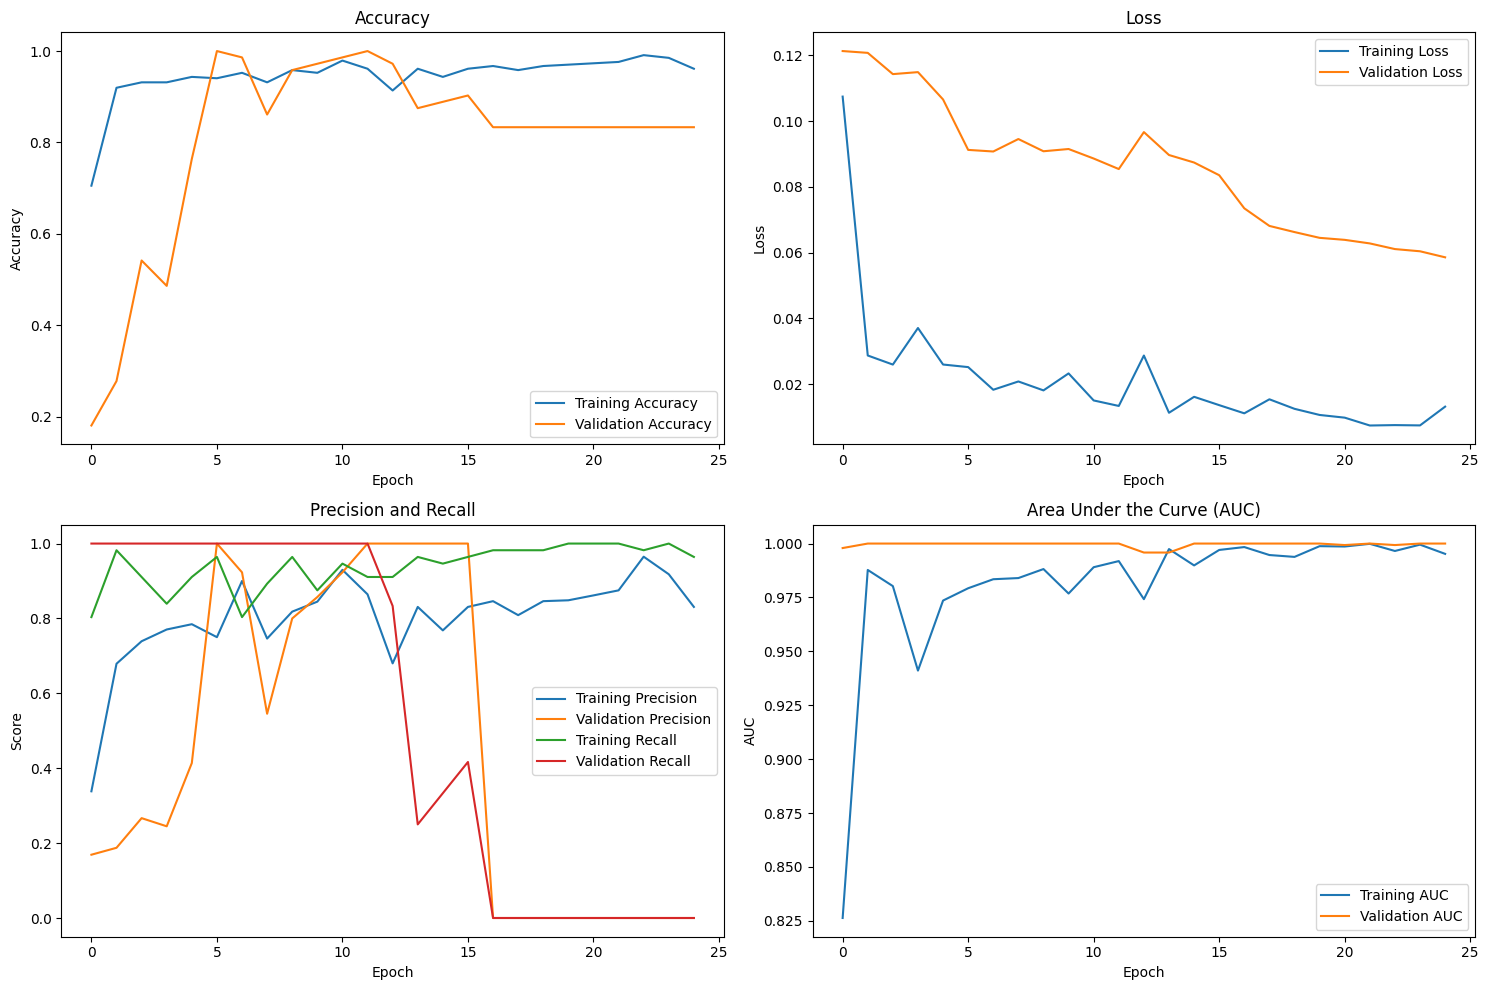


Evaluating on test set...
3/3 [==============================] - 37s 6s/step - loss: 0.0880 - accuracy: 0.9167 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000
Test loss: 0.0880
Test accuracy: 0.9167
Test precision: 1.0000
Test recall: 0.5000
Test AUC: 1.0000


In [ ]:
print("\n=== Step 8: Evaluating the model ===")

# Combine histories for plotting
history = {}
for key in history1.history:
    if key in history2.history:
        history[key] = history1.history[key] + history2.history[key]
    else:
        history[key] = history1.history[key]

# Plot training history
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot precision and recall
plt.subplot(2, 2, 3)
plt.plot(history['precision'], label='Training Precision')
plt.plot(history['val_precision'], label='Validation Precision')
plt.plot(history['recall'], label='Training Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.title('Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Plot AUC
plt.subplot(2, 2, 4)
plt.plot(history['auc'], label='Training AUC')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('Area Under the Curve (AUC)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test precision: {test_results[2]:.4f}")
print(f"Test recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

# Function to predict on a batch and calculate metrics
def predict_and_evaluate(dataset):
    y_true = []
    y_pred = []
    y_prob = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int).flatten())
        y_prob.extend(predictions.flatten())

    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Thalassemia (RBC)', 'Thalassemia (PBS)']))

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve (better for imbalanced datasets)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    average_precision = average_precision_score(y_true, y_prob)

    # Plot ROC curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Thalassemia', 'Thalassemia'], rotation=45)
    plt.yticks(tick_marks, ['Non-Thalassemia', 'Thalassemia'])

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return y_true, y_pred, y_prob



=== Step 10: Visualizing predictions ===
Predictions with default threshold (0.5):
1/1 [==============================] - 2s 2s/step


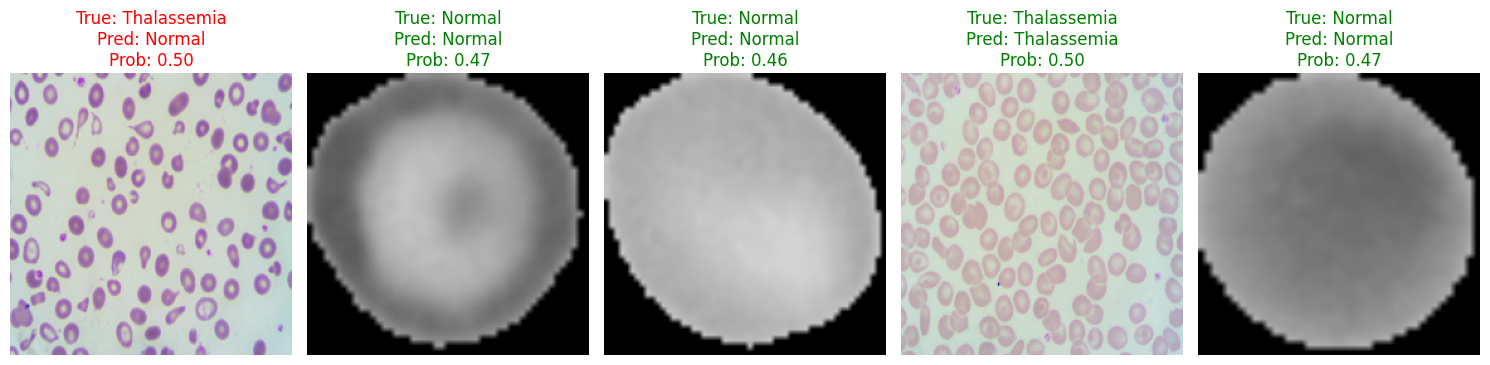

Predictions with optimal threshold (0.4914):
1/1 [==============================] - 2s 2s/step


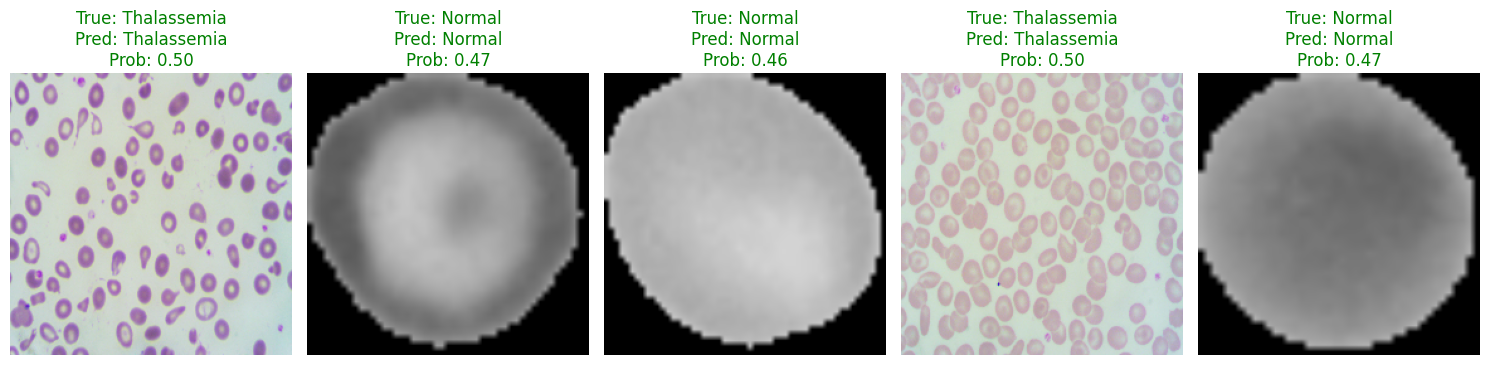


Training complete! The model has been saved as 'final_thalassemia_model.h5'

=== Deployment Information ===
To use this model for inference:
1. Load the model: model = tf.keras.models.load_model('final_thalassemia_model.h5')
2. Preprocess images: resize to (224, 224) and normalize to [0, 1]
3. Use the optimal threshold of 0.4914 for classification
4. Interpret results: 0 = Non-Thalassemia, 1 = Thalassemia


In [ ]:
print("\n=== Step 10: Visualizing predictions ===")

def visualize_predictions(dataset, threshold=0.5, num_samples=5):
    # Get a batch of images and labels
    images_to_show = []
    labels_to_show = []

    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            images_to_show.append(images[i].numpy())
            labels_to_show.append(labels[i].numpy())

    # Make predictions
    predictions = model.predict(np.array(images_to_show))
    pred_labels = (predictions > threshold).astype(int).flatten()

    # Plot images with predictions
    plt.figure(figsize=(15, 10))
    for i in range(len(images_to_show)):
        plt.subplot(1, len(images_to_show), i+1)
        plt.imshow(images_to_show[i])

        true_label = "Thalassemia" if labels_to_show[i] == 1 else "Normal"
        pred_label = "Thalassemia" if pred_labels[i] == 1 else "Normal"
        color = "green" if labels_to_show[i] == pred_labels[i] else "red"

        plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {predictions[i][0]:.2f}",
                 color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize with default threshold
print("Predictions with default threshold (0.5):")
visualize_predictions(test_ds)

# Visualize with optimal threshold
print(f"Predictions with optimal threshold ({best_threshold:.4f}):")
visualize_predictions(test_ds, threshold=best_threshold)

# Step 11: Save the final model
model.save('final_thalassemia_model.h5')
print("\nTraining complete! The model has been saved as 'final_thalassemia_model.h5'")

# Additional information for deployment
print("\n=== Deployment Information ===")
print("To use this model for inference:")
print("1. Load the model: model = tf.keras.models.load_model('final_thalassemia_model.h5')")
print("2. Preprocess images: resize to (224, 224) and normalize to [0, 1]")
print(f"3. Use the optimal threshold of {best_threshold:.4f} for classification")
print("4. Interpret results: 0 = Non-Thalassemia, 1 = Thalassemia")

In [ ]:
def visualize_multiple_batches(dataset, threshold=0.5, batches=3, num_samples_per_batch=5):
    for batch_num, (images, labels) in enumerate(dataset.take(batches)):
        print(f"\n--- Batch {batch_num + 1} ---")
        images_to_show = []
        labels_to_show = []

        for i in range(min(num_samples_per_batch, len(images))):
            images_to_show.append(images[i].numpy())
            labels_to_show.append(labels[i].numpy())

        # Make predictions
        predictions = model.predict(np.array(images_to_show))
        pred_labels = (predictions > threshold).astype(int).flatten()

        # Plot images with predictions
        plt.figure(figsize=(15, 5))
        for i in range(len(images_to_show)):
            plt.subplot(1, len(images_to_show), i+1)
            plt.imshow(images_to_show[i])

            true_label = "Thalassemia" if labels_to_show[i] == 1 else "Normal"
            pred_label = "Thalassemia" if pred_labels[i] == 1 else "Normal"
            color = "green" if labels_to_show[i] == pred_labels[i] else "red"

            plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {predictions[i][0]:.2f}",
                     color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()



--- Batch 1 ---
1/1 [==============================] - 4s 4s/step


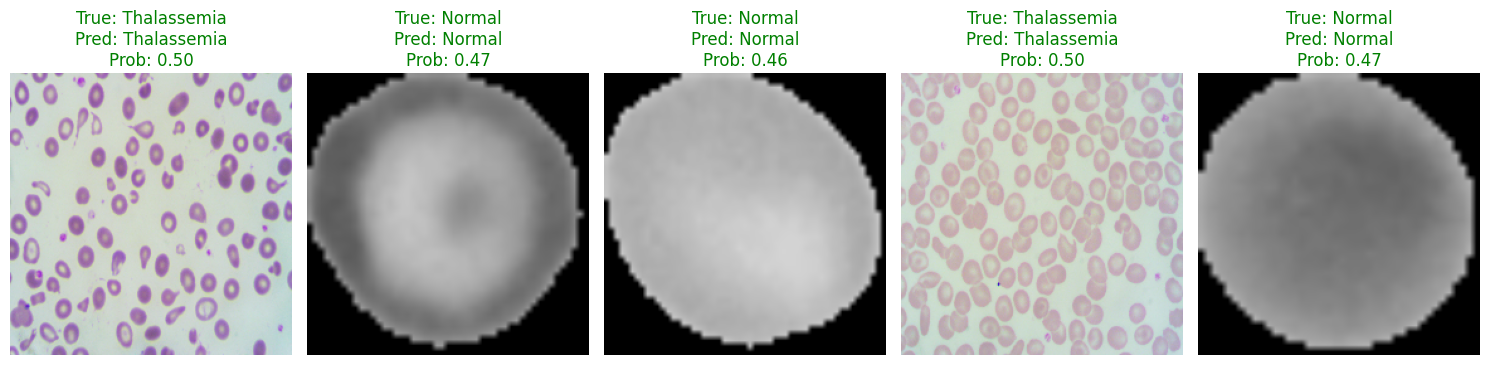


--- Batch 2 ---
1/1 [==============================] - 2s 2s/step


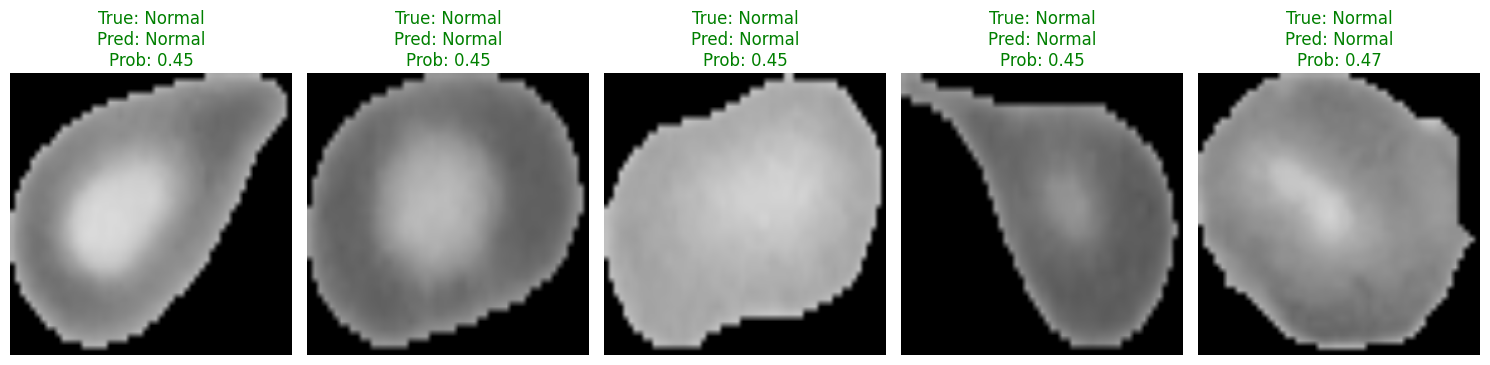


--- Batch 3 ---
1/1 [==============================] - 2s 2s/step


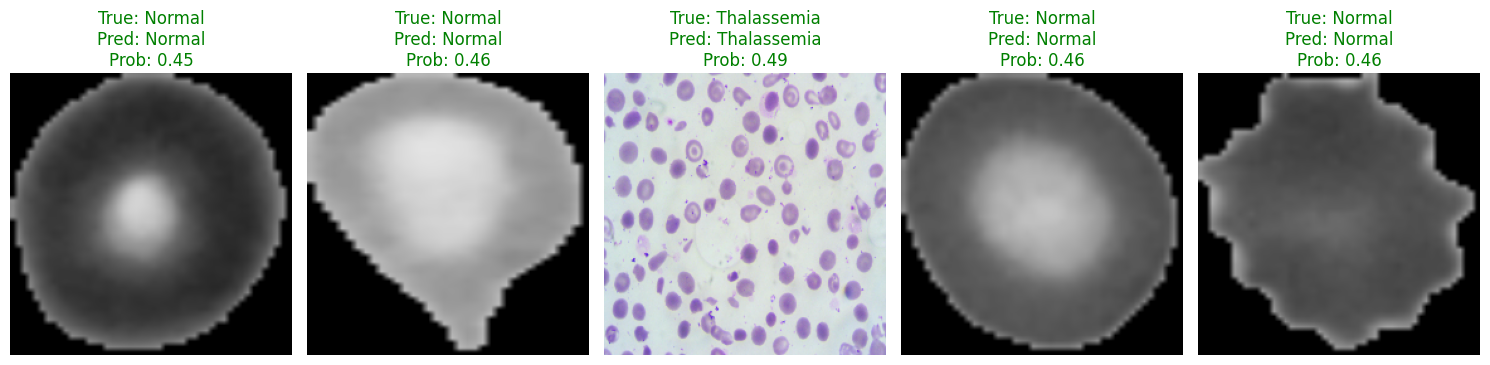

In [ ]:
visualize_multiple_batches(test_ds, threshold=best_threshold, batches=3)


1/1 [==============================] - 8s 8s/step


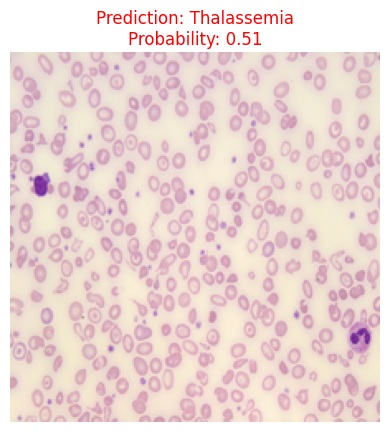

1/1 [==============================] - 0s 362ms/step


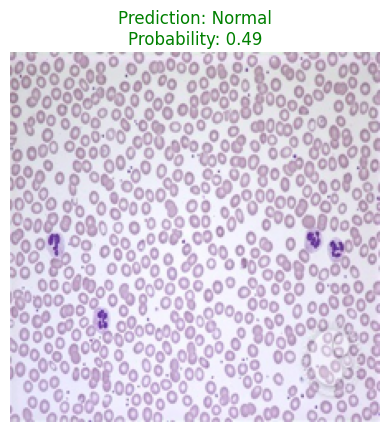

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

# Load your saved model
model = tf.keras.models.load_model('final_thalassemia_model.h5')

# Set image size (adjust if your model expects a different input shape)
IMG_SIZE = (224, 224)

# Helper function to preprocess and predict
def predict_image(image_path, threshold=0.5):
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "Thalassemia" if prediction > threshold else "Normal"
    color = "green" if label == "Normal" else "red"

    # Display
    plt.imshow(img)
    plt.title(f"Prediction: {label}\nProbability: {prediction:.2f}", color=color)
    plt.axis('off')
    plt.show()

# Paths to uploaded images
image1_path = "image1.png"
image2_path = "image2.png"

# Use the best threshold from your training (replace best_threshold with actual value)
predict_image(image1_path, threshold=best_threshold)
predict_image(image2_path, threshold=best_threshold)


In [ ]:
from google.colab import files
files.download('final_thalassemia_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("aiprojectmodel.h5")


In [ ]:
from tensorflow import keras

# Load from h5
model = keras.models.load_model("aiprojectmodel.h5")

# Save to SavedModel format
model.save("aiprojectmodel", save_format="tf")


In [ ]:
!zip -r aiprojectmodel.zip aiprojectmodel


  adding: aiprojectmodel/ (stored 0%)
  adding: aiprojectmodel/fingerprint.pb (stored 0%)
  adding: aiprojectmodel/variables/ (stored 0%)
  adding: aiprojectmodel/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: aiprojectmodel/variables/variables.index (deflated 77%)
  adding: aiprojectmodel/assets/ (stored 0%)
  adding: aiprojectmodel/saved_model.pb (deflated 92%)
  adding: aiprojectmodel/keras_metadata.pb (deflated 96%)


In [ ]:
from google.colab import files
files.download("aiprojectmodel.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras
import numpy as np
import streamlit as st
import PIL

# Print versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Streamlit version: {st.__version__}")
print(f"PIL/Pillow version: {PIL.__version__}")

TensorFlow version: 2.12.0
Keras version: 2.12.0
NumPy version: 1.23.5
Streamlit version: 1.44.1
PIL/Pillow version: 11.1.0


In [ ]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
